In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_recall_fscore_support
from matplotlib import pyplot as plt
from sklearn.preprocessing import binarize

In [2]:
from glob import glob
feature_fns = glob("../features2/*_input.csv")
# feature_fns = ['../features/measure_input.csv',
#  '../features/drug_input.csv',
#  '../features/procedure_input.csv',
#  '../features/observation_input.csv',
#  '../features/condition_input.csv']

In [3]:
def fmax_score(labels, predictions, beta = 1.0, pos_label = 1):
    precision, recall, _ = precision_recall_curve(labels, predictions, pos_label)
    f1 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return np.nanmax(f1)

In [4]:
def individual_feature_LR(fn):
    ## read in features and labels
    feature_name = fn.split("/")[-1].split("_")[0]
    
    data = pd.read_csv(fn, index_col=0)
    deaths = np.array(data.death)
    features = data.drop(columns=["death"]).values
    
    kf = KFold(n_splits=5,random_state=2019,shuffle=False)
    kf.get_n_splits(features)
    
    figs_dict = {}
    performance_dfs = []
    
    i = 0
    for train_index, test_index in kf.split(features):
        i += 1
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = deaths[train_index], deaths[test_index]
        
        lr = LR(class_weight={1:0.8,0:0.2})
        lr.fit(X_train,y_train)
        y_pred = lr.predict_proba(X_test)[:,1]
        
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        
        auc = roc_auc_score(y_test, y_pred)
        fmax = fmax_score(y_test, y_pred)
        
        performance_df = pd.DataFrame({"score":[auc, fmax], "eval_method":["AUC","F-Max"], "fold":[i,i]})
        performance_df["feature"] = feature_name
        
        performance_dfs.append(performance_df)

        
    performance_dfs = pd.concat(performance_dfs)

    return performance_dfs

In [7]:
from os.path import exists
from os import mkdir
import seaborn as sns

perf_dfs = []
if not exists("../results/"):
    mkdir("../results/")
    
for fn in feature_fns:
    perf_df = individual_feature_LR(fn)
    feature_name = fn.split("/")[-1].split("_")[0]
    perf_dfs.append(perf_df)
    #plt.savefig("../results/%s_pre_rec_curve.png" %feature_name)

perf_dfs = pd.concat(perf_dfs)

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid val

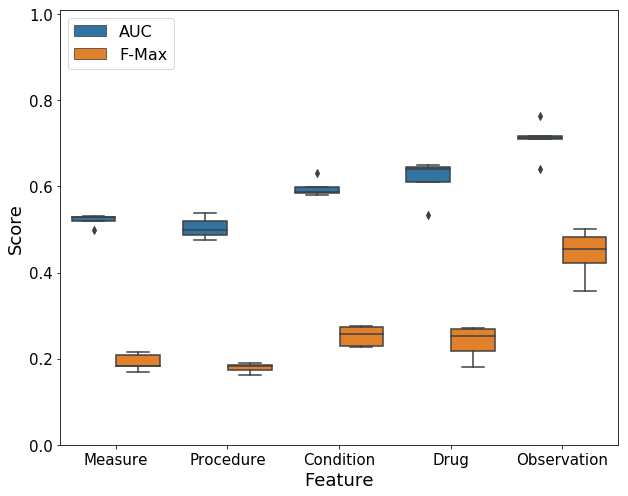

In [10]:
f = plt.figure(figsize=(10,8))
sns.boxplot(data=perf_dfs, hue="eval_method", x="feature", y="score", order=["measure", "procedure", "condition","drug", "observation"])

plt.xlabel("Feature", fontsize=18)
plt.ylabel("Score", fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc=2, prop={'size': 16})
plt.xticks(range(5),["Measure", "Procedure", "Condition","Drug", "Observation"], fontsize=15)
plt.ylim(0,1.01)
plt.savefig("individual_performance_180.png", bbox_inches="tight")
plt.show()
plt.close()